In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score,auc
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.classifier import ClassificationReport, ROCAUC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

### Problem Description:
 A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service")

### Loading the data

In [2]:
data = pd.read_csv('Tweets.csv')
data.shape

(14640, 15)

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
### Creating new feature for EDA

In [5]:
data['tweet_created'] = pd.to_datetime(data['tweet_created'])
data['tweet_date']= data['tweet_created'].apply(lambda x: x.date())

### EDA
 - #### Sentimental Analysis by Airlines
  - In terms of numbers, United Airlines has more negative tweets followed by US Airways and American Airlines
  - In terms of percentage, US Airways has more negative tweets followed by American Airlines and United
  - Virgin Airlines has more positive tweets in terms of percentage while Delta has more positive tweets in terms of numbers

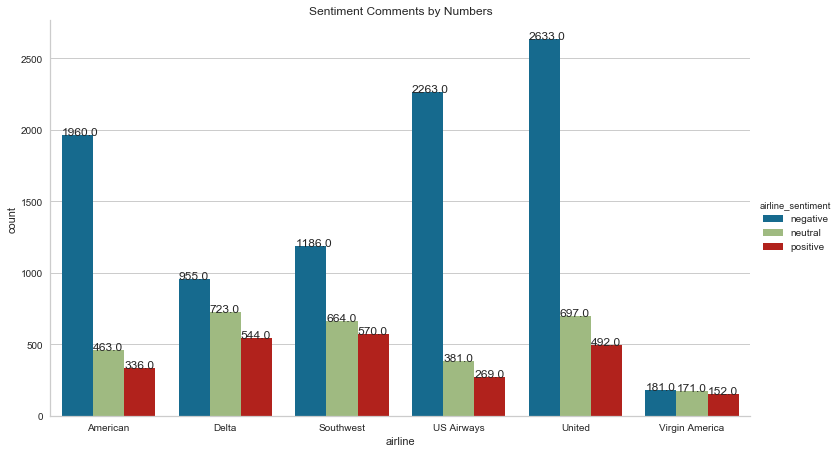

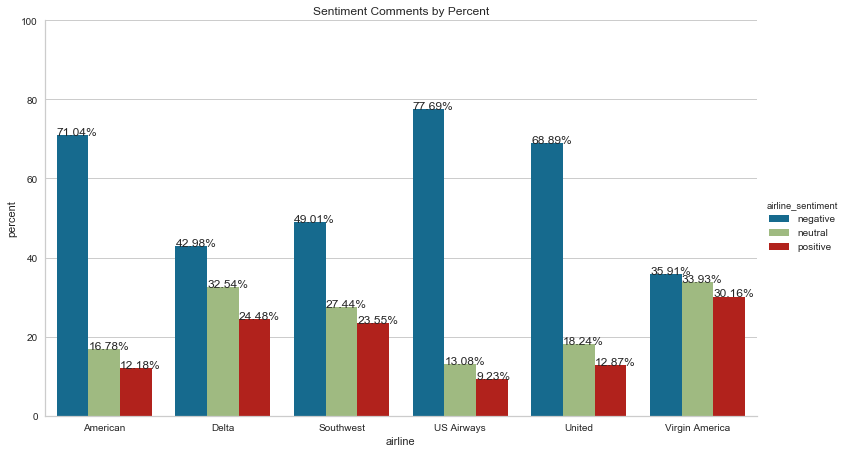

In [6]:
x, y = 'airline','airline_sentiment'


data_agg = data.groupby(x)[y].value_counts().rename('count').reset_index()

g = sns.catplot(x=x,y='count',hue=y,kind='bar',data=data_agg, height=6.27, aspect=10.7/6.27)
# g.ax.set_ylim(0,100)
g.ax.set_title('Sentiment Comments by Numbers')



for p in g.ax.patches:
    txt = str(p.get_height())
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
 

x, y = 'airline','airline_sentiment'


data_agg = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=data_agg, height=6.27, aspect=10.7/6.27)
g.ax.set_ylim(0,100)
g.ax.set_title('Sentiment Comments by Percent')

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

#### Negative Reasons Analysis
 - Customer Service Issue is the top category in the negative reasons followed by Late Flight and cancelled flight
 - All the airlines has the same top 2 cateogories except for Delta where late flight is more concerning issue rather than Customer service issue


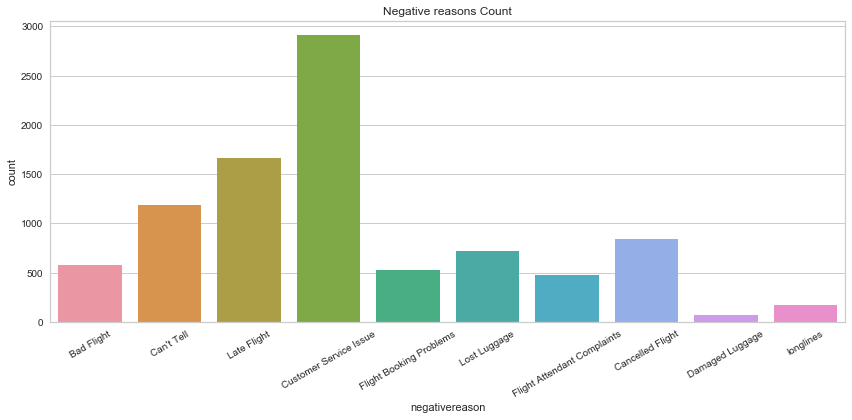

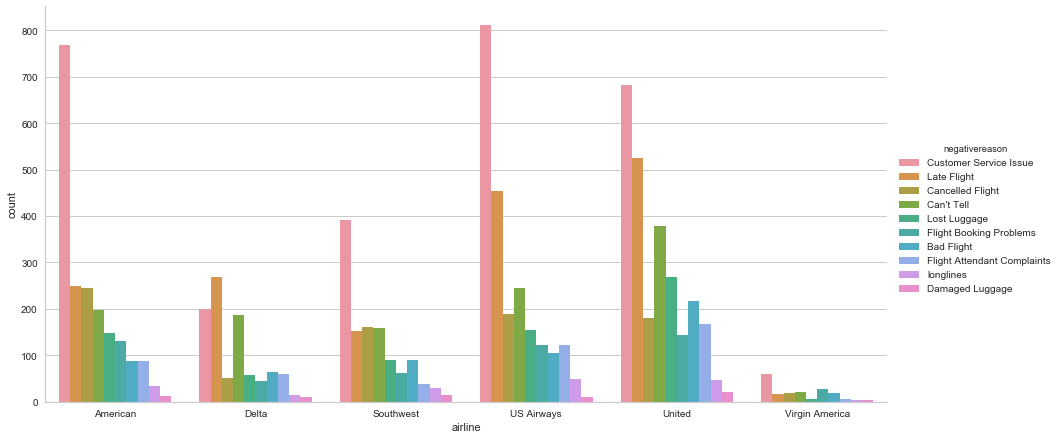

In [7]:
plt.figure(figsize=(12,6))
g = sns.countplot(data['negativereason'])
plt.xticks(rotation=30)
plt.title("Negative reasons Count")
plt.tight_layout()

x, y = 'airline','negativereason'
data_agg = data.groupby(x)[y].value_counts().rename('count').reset_index()

g = sns.catplot(x=x,y='count',hue=y,kind='bar',data=data_agg, height=6.27, aspect=14.7/7.27)

### Tweet Analysis by Date
 - More Tweet occured on 22nd and 23rd
 - Interestingly for American Airlines no tweets after 24th
 - For Southwest airlines comparitively more tweets occured on 17th Feb

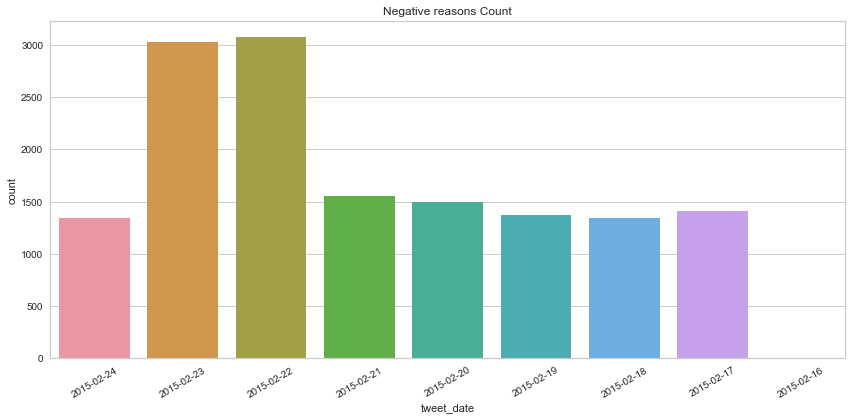

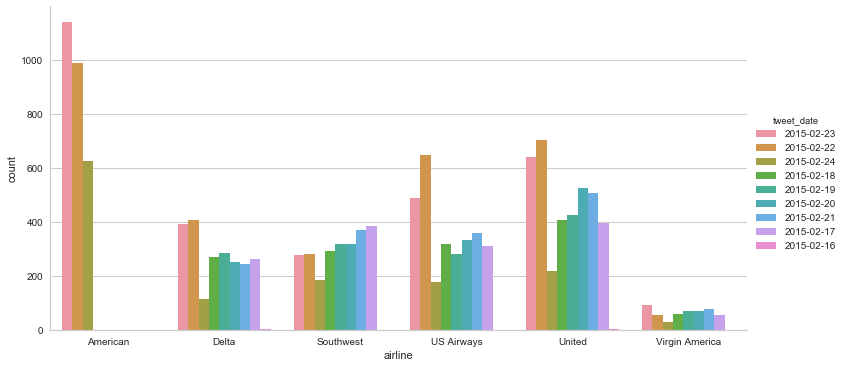

In [8]:
plt.figure(figsize=(12,6))
g = sns.countplot(data['tweet_date'])
plt.xticks(rotation=30)
plt.title("Negative reasons Count")
plt.tight_layout()

x, y = 'airline','tweet_date'
data_agg = data.groupby(x)[y].value_counts().rename('count').reset_index()

g = sns.catplot(x=x,y='count',hue=y,kind='bar',data=data_agg, height=5.27, aspect=14.7/7.27)

### Text Preprocessing
 - Removing @mentions
 - Removing non-alphabets with blank (Accounting for html tags, puncutation and numbers)
 - Converting all words to lower
 - Removing Stopwords

In [9]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords


stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))   

def preprocess_text(tweet):
    remove_mentions = re.sub(r'@\w+', '', tweet) ## removing @ mentions
    http_clean = " ".join([word for word in remove_mentions.split() if 'http' not in word and word != 'RT'])
    alpha_characters = re.sub("[^a-zA-Z]", " ",http_clean) ## Removing non alphabets with blank
    words = alpha_characters.lower()
    word_tokens = word_tokenize(words)  # Tokenization
    stop_word_removed = [word for word in word_tokens if word not in stopwords]
    porter = SnowballStemmer("english")
    stemmed = [porter.stem(word) for word in stop_word_removed]
    return( " ".join( stemmed )) 




In [10]:
data['preprocessed_text']= data['text'].apply(preprocess_text)
data_preprocessed = data[['preprocessed_text','airline_sentiment']]
data_preprocessed.head()

,preprocessed_text,airline_sentiment
0,said,neutral
1,plus ad commerci experi tacki,positive
2,didn today must mean need take anoth trip,neutral
3,realli aggress blast obnoxi entertain guest fa...,negative
4,realli big bad thing,negative


In [11]:
X = data_preprocessed['preprocessed_text']
y = data_preprocessed['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


### Model using CountVectorizer

In [12]:
cv = CountVectorizer(analyzer='word')
train_features = cv.fit_transform(X_train)
test_features = cv.transform(X_test)

In [13]:
def compare_base_models(X_train, y_train, X_test, y_test):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=50)))
    models.append(('GB', GradientBoostingClassifier(n_estimators=50)))
    models.append(('Adaboost', AdaBoostClassifier(n_estimators=50)))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        model_fit = model.fit(X_train, y_train)
        y_pred = model_fit.predict(X_test)
        accuracy = accuracy_score(y_test,y_pred)
        results.append([name,accuracy])

    results = pd.DataFrame(results,columns=['Model','Accuracy'])
    return results

In [14]:
compare_base_models(train_features, y_train, test_features, y_test)

,Model,Accuracy
0,LR,0.798497
1,CART,0.711066
2,RF,0.771858
3,GB,0.722336
4,Adaboost,0.724044


### Inference :
 - From the accuracy standpoint, Logisitc regression base model giving better accuracy over the others. Further trying to optimize the performance using RandomSearch

In [15]:
from IPython.display import display, Markdown
def get_classification_report(X_train, y_train, X_test, y_test,model):
    
    # Visualize model performance with yellowbrick library
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display(Markdown("### Accuracy of the Model"))
    print(accuracy_score(y_test,y_pred))
    
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    roc = ROCAUC(model)
    roc.fit(X_train, y_train)
    roc.score(X_test, y_test)
    roc.show()
    

In [16]:
lr = LogisticRegression()
param_grid = {'C': np.linspace(0.001, 1,10),
               'penalty': ['l1','l2'],
               'fit_intercept':[True, False]
             }

lr_random = RandomizedSearchCV(estimator = lr, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
lr_random.fit(train_features, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2']},
              

### Accuracy of the Model

0.7984972677595629


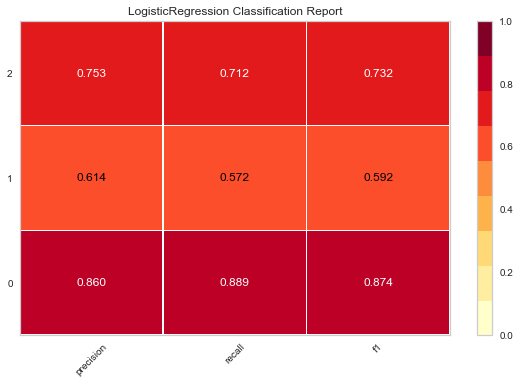

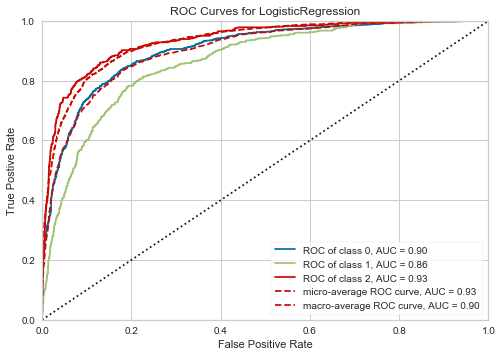

In [17]:
lr_model = lr_random.best_estimator_
get_classification_report(train_features,y_train, test_features,y_test, lr_model)

### Model using Tfidf

In [18]:
tfidf = TfidfVectorizer()
train_features_tfidf = tfidf.fit_transform(X_train)
test_features_tfidf = tfidf.transform(X_test)

In [19]:
compare_base_models(train_features_tfidf, y_train, test_features_tfidf, y_test)

,Model,Accuracy
0,LR,0.795082
1,CART,0.718921
2,RF,0.782104
3,GB,0.730533
4,Adaboost,0.728142


In [20]:
lr = LogisticRegression()
param_grid = {'C': np.linspace(0.001, 1,10),
               'penalty': ['l1','l2'],
               'fit_intercept':[True, False]
             }

lr_random = RandomizedSearchCV(estimator = lr, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
lr_random.fit(train_features_tfidf, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2']},
              

### Accuracy of the Model

0.7940573770491803


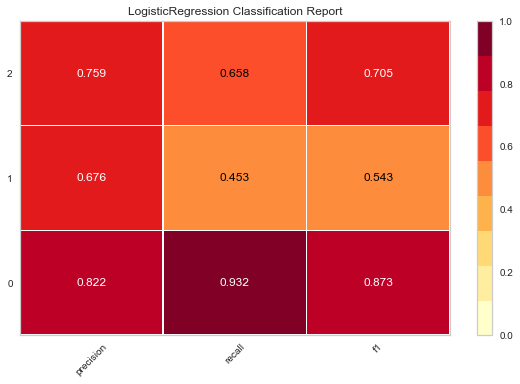

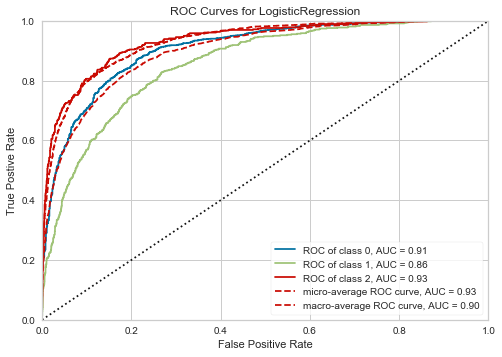

In [21]:
lr_model = lr_random.best_estimator_
get_classification_report(train_features_tfidf,y_train, test_features_tfidf,y_test, lr_model)

### Conclusion
 - Logistic Regression outperformed the boosting and bagging models both using TFIDF and CountVectorizer
 - Logistic Regression using TFIDF has slightly higher performance in terms of accuracy and roc value

### Deep learning model using LSTM

In [22]:
# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

# Deep Learning Model - Keras - CNN




# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional,SpatialDropout1D

# Deep Learning Model - Keras - General
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten




# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Deep Learning Callbacs - Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau



In [23]:
X = data_preprocessed['preprocessed_text']
y = data_preprocessed['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train_keras = to_categorical(y_train)
y_test_keras = to_categorical(y_test)

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()


max_words, max_len

(7503, 118)

### Using Toeknization and Padding

In [24]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_len)

### Building the LSTM model

In [25]:
embedding_vecor_length = 32
batch_size=64
epochs=30
model = Sequential()

model.add(Embedding(max_words, 100, input_length=max_len))
model.add(LSTM(256))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))


# model.add(Embedding(max_words, embedding_vecor_length, input_length=max_review_length))
# model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = history = model.fit(X_train_seq, y_train_keras, epochs=epochs, batch_size=batch_size,validation_split=0.2,\
                              callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
# Final evaluation of the model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 118, 100)          750300    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [26]:
scores = model.evaluate(X_test_seq, y_test_keras, verbose=0)
scores
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 75.44%


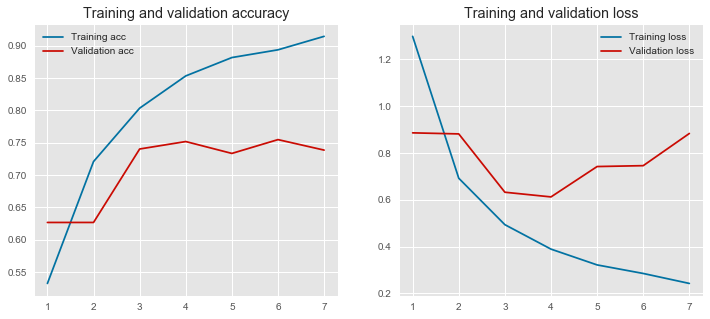

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

### Conclusion
 - In this specific case, with limited data and compute , LSTM model (not performed hyperparameter optimization due to restrictions with compute) performing comparitively less than Logistic regression model